In [7]:
import requests

import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
from geopy import distance
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV


from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString, MultiPolygon

In [13]:
train = pd.read_csv('mf_geo_train.csv')
test = pd.read_csv('mf_geo_test.csv')

In [14]:
borders_rus = gpd.read_file('admin_level_4.geojson') # области россии
bord_msc_spb = gpd.read_file('admin_level_8.geojson') # районы мск и спб

In [15]:
#удаляем москву и спб из областей россии
borders_rus_droped = borders_rus.drop([45,64])

In [16]:
borders = pd.concat((borders_rus_droped,bord_msc_spb))

<AxesSubplot:>

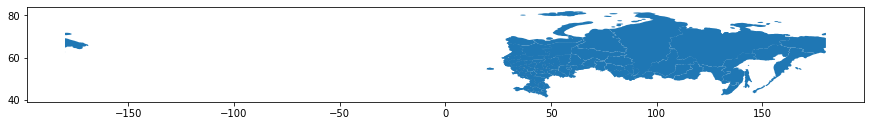

In [17]:
borders.plot(figsize=(15,15))

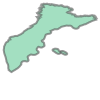

In [18]:
borders_rus.geometry.iloc[1]

In [8]:
train_geo = gpd.GeoDataFrame(train, geometry=gpd.points_from_xy(train.lon, train.lat))
test_geo = gpd.GeoDataFrame(test, geometry=gpd.points_from_xy(test.lon, test.lat))

джоиним 

In [323]:
train_geo = gpd.sjoin(train_geo, borders[['name','geometry']], op='within')
test_geo = gpd.sjoin(test_geo, borders[['name','geometry']], op='within')

train_geo.drop(['index_right'],axis=1,inplace=True)
test_geo.drop(['index_right'],axis=1,inplace=True)

D:\Progi\Anaconda\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  "(%s != %s)" % (left_df.crs, right_df.crs)


Подмешаем таргет в датафрейм, добавим среднюю цену по райнону

In [12]:
for i in train_geo.name.unique():
    train_geo.loc[train_geo.name == i, 'target_mean'] = train_geo[train_geo.name ==i].target.mean()

# Грузим с OSM

<b>Попробуем добавить amenitу:</b><br>вокзалы/станции метро<br>фаст фуд<br>банки<br>кафе<br>таулеты

In [14]:
# очерчиваем bbox вокруг точки продажи
def box(df,point): 
    lon_max = df[df.point_id == point].lon.max() + 0.005
    lon_min = df[df.point_id == point].lon.min() - 0.005
    lat_max = df[df.point_id == point].lat.max() + 0.005
    lat_min = df[df.point_id == point].lat.min() - 0.005


    m_bbox = lat_min,lon_min,lat_max,lon_max
    return m_bbox

In [15]:
def amenity_counter(df,point):
    overpass_url = "http://overpass-api.de/api/interpreter"

    #Запрос на вокзалы/метро
    overpass_query = '''
    [out:json];
    ( 
       node["public_transport"="station"]({},{},{},{});
    );
    out center;
    '''.format(*box(df,point))
    response = requests.get(overpass_url, 
                            params={'data': overpass_query})
    amenity = response.json()
    amenity_osm = pd.DataFrame(amenity['elements'])
    number_of_stations = amenity_osm.shape[0]
    
    #Запрос на банки
    overpass_query = '''
    [out:json];
    ( 
       node["amenity"="bank"]({},{},{},{});
    );
    out center;
    '''.format(*box(df,point))

    response = requests.get(overpass_url, 
                            params={'data': overpass_query})
    amenity = response.json()
    amenity_osm = pd.DataFrame(amenity['elements'])
    number_of_banks = amenity_osm.shape[0]  

    #Запрос на фастбуд 
    overpass_query = '''
    [out:json];
    ( 
       node["amenity"="fast_food"]({},{},{},{});
    );
    out center;
    '''.format(*box(df,point))

    response = requests.get(overpass_url, 
                            params={'data': overpass_query})
    amenity = response.json()
    amenity_osm = pd.DataFrame(amenity['elements'])
    number_of_ff = amenity_osm.shape[0]   

    #Запрос на кафе   
    overpass_query = '''
    [out:json];
    ( 
       node["amenity"="cafe"]({},{},{},{});
    );
    out center;
    '''.format(*box(df,point))

    response = requests.get(overpass_url, 
                            params={'data': overpass_query})
    amenity = response.json()
    amenity_osm = pd.DataFrame(amenity['elements'])
    number_of_cafes = amenity_osm.shape[0]   

    #Запрос на уборные 
    overpass_query = '''
    [out:json];
    ( 
       node["amenity"="toilets"]({},{},{},{});
    );
    out center;
    '''.format(*box(df,point))

    response = requests.get(overpass_url, 
                            params={'data': overpass_query})
    amenity = response.json()
    amenity_osm = pd.DataFrame(amenity['elements'])
    number_of_toilets = amenity_osm.shape[0]       
    
    
    df.loc[df.point_id == point, 'stations'] = number_of_stations
    df.loc[df.point_id == point, 'banks'] = number_of_banks
    df.loc[df.point_id == point, 'fast_food'] = number_of_ff 
    df.loc[df.point_id == point, 'cafe'] = number_of_cafes
    df.loc[df.point_id == point, 'toilet'] = number_of_toilets

Добавляем в трейн amenity

In [16]:
for pnt in train_geo.point_id:
    amenity_counter(train_geo,pnt)

ommNZCUV
wXDJYllD
3Ix3aKz2
f9UjG9j3
nMe2LHPb
0yC9gVuF
zg9Rqx6j
ZgodVRqB
CHtHXJLp
sgrEW5hG
B8K3Fzd0
7T3FujXu
49RGSbXb
GT8iSIX9
ALeY6VVA
A2xt33Am
SXJSzE6M
uFWtwbd5
O1UQUy36
1qYX1KZb
p4OinUCs
9hCdPw1R
PIdoZHEy
lvkMDIOb
lFH5jSIm
mU5wwKjd
YQ7ziyzt
zaG5km8I
0t2jNYdz
s8LhdRDp
3VbIMBNL
960M6jye
U27W4QJ7
5WiIuenb
HtEs9cWZ
DZnacIGm
AA8hN7bJ
ci9r9Fr2
GU0QclY1
ejjC2aU3
Fcqb4WDt
NTjDKBtL
2cU1Z8KM
9RIuAGT0
NF33CYqv
HccXdHMK
y7s9SVJ9
P9mGf44m
y5XqCNW4
9vpi0zuV
jg4KN4rk
h6qIFhXA
5z5VpTGn
fP7JB9Qs
59rpwZBk
bwmFXfeI
6HXoX1HZ
O3tOF6uE
CO76tdVs
FghElX6D
XPqFCntc
tJMGAXxW
1ZvdVY5t
nh41SLK0
jvXZ5BfY
kcPx2crY
eAjJXePD
nFBsJ5k3
bwIuFswf
TPU9VeHE
iL9SqqPf
cj6KcHW8
x5YyYuwn
9IcvdlDF
zrqrRf0q
mn6nMLpV
ySZshzYS
m41j6rrW
5e7r5h7s
6FdFnHvc
f0dnYtDK
zRh8HUje
GLpUl6ku
ZDyDKUmb
4LvQzaA9
3bqwQXqD
aWMomlO7
ny5swWUO
Tw1Svbiw
nGW7MYJ2
K3gR6qAk
qbrgrMBr
Zg57ss59
y3wFGx0E
YscCLNMq
ZopCnYnF
A4nv1Vap
3mtxtQsE
MJFHjv6Q
FMPuwbsj
6baGVy1n
Wf730kFc
F9XOYlnb
AvrNG4Gf
oeiKBQIm
oEOiQlpv
Nj7qV6KG
oVuxDTxV
E2fZAexI
9BqGtCOu
I0hubgK0
6

In [17]:
# сохраняем, потому что очень долго считает 
train_geo.to_csv('train_geo1.csv', index=False)

Добавляем в тест датафрейм amenity

In [18]:
for pnt in test_geo.point_id:
    amenity_counter(test_geo,pnt)

F4lXR1cG
4LJu4GTf
QquqDdRl
TWUIwCah
6PiHBiPm
kuGZ4yXA
kLuAAN3s
LbLThb6j
OxQHvaNu
kDCyn0Ha
paQsTa1K
tiPNVf91
OouVT4Zr
aLy2kqTV
JidKSH2R
MeNZuzDB
TbDJ2RgS
7x7uZwPc
OMCMewkC
yCrOWDXH
eek3uK7b
1ndpxE65
Ah6sXXfa
MRwaez8q
m9h9lzCE
0dALVmD0
6vsM74Ui
wU3Bwy5N
sjERvBid
fySKKBdl
xoC8SVZ6
6Q7KBAoT
plGMM2CY
gpPhWECC
SAG5ZauI
P1vXR2pG
AJ47SPyN
PaTk77uz
QkXAaBQz
cBaNbClS
SqzIUo9E
dPq6TowN
ZY12DIQW
RucPRBbc
hfO83LAD
kKsmoCEr
LNKVC212
ugpDLEgl
koUetlmm
YGJryxQa
isUPO5Tx
m4yaXKko
7int6k3y
LmTkI4PU
VfCYSRPo
jUjQH6FF
jUaTdyYV
lsX5obPS
uueFkM3M
ZjsVlgzG
BmtPMEBg
lUhGuoch
ZeaM9y86
BPLBCrjY
io4giw9z
9sEjiwLZ
WRf9qCgC
2VNvJAyN
9um9WSSk
4nmfqUw0
N9O45mAh
U3SG8Irc
QlZzfZrW
skVjLBYY
mdi0WTpI
oMbCJgbo
e4AtKUtT
uEumvYxb
zfHzfmQG
A8P3Z3Sj
U24Br79u
09nncz2H
Qehnn1gC
Td6xexBc
RAxzkFsk
5IMsPh3S
L4gshXix
5NQiL53e
y09rLpIJ
Si8Vy26J
y8oQuX5v
7wJW3BCz
v1T3aod4
vstSch3z
3tvzdkSw
Kz16eeT9
brKMgzgn
21sDnd2f
OvdClpSy
Fk1RC0V1
f91ZeyYl
f5PpqpoR
b8VUVBle
h3S4qdms
BEh6jJ04
h2InCLKa
TQKiIgFt


In [54]:
test_geo.to_csv('test_geo1.csv', index=False)

# Добавим фичу - расстояние до ближайшего вокзала/метро

In [23]:
#Очерчиваем бокс, в котором находятся все точки + еще 1 градус
lon_min = np.minimum(test_geo.lon.min(),train_geo.lon.min()) - 1
lon_max = np.maximum(test_geo.lon.max(),train_geo.lon.max()) + 1
lat_min = np.minimum(test_geo.lat.min(),train_geo.lat.min()) - 1
lat_max = np.maximum(test_geo.lat.max(),train_geo.lat.max()) + 1
station_box = lat_min,lon_min,lat_max,lon_max

In [24]:
#Загружаем все вокзалы из ббокса
overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query = '''
[out:json];
( 
node["public_transport"="station"]({},{},{},{});
);
out center;
'''.format(*station_box)

response = requests.get(overpass_url, 
                     params={'data': overpass_query})
amenity = response.json()

amenity_osm = pd.DataFrame(amenity['elements'])

In [25]:
# находим ближайший вокзал
def station_dist(df):
    for point in df.point_id: 
        a = []
        point_coord = df[df.point_id==point].lat.values, df[df.point_id==point].lon.values

        for i in range(amenity_osm.shape[0]):
            station_coord = amenity_osm.iloc[i].lat,amenity_osm.iloc[i].lon
            a.append(distance.geodesic(point_coord,station_coord).m)
        # id ближайшего вокзала из amenity_osm   
        idx_nearest = a.index(np.array(a).min())
        df.loc[df.point_id == point, 'station_dist'] = np.array(a).min()

In [68]:
station_dist(train_geo)
# сохраняем потому что долго считает
train_geo.to_csv('train_geo.csv', index=False)

In [67]:
station_dist(test_geo)
test_geo.to_csv('test_geo.csv', index=False)

In [324]:
# загружаем
#train_geo = pd.read_csv('/train_geo.csv')
# test_geo  = pd.read_csv('/test_geo.csv')

In [325]:
#Добавим target_mean в тест
for i in train_geo.name.unique():
    test_geo.loc[test_geo.name == i  ,'target_mean'] = train_geo[train_geo.name==i].target_mean.iloc[0]

В тесте есть магазины из районов Мск и СПб, которы нет в трейне, соотвественно среднего таргета по району для них тоже нет, найдем среднее значение по Мск и СПб и вставим в эти районы

In [326]:
a = gpd.GeoDataFrame(train, geometry=gpd.points_from_xy(train.lon, train.lat))

In [327]:
b = gpd.sjoin(a, borders_rus[['name','geometry']], op='within')

D:\Progi\Anaconda\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [328]:
for i in b.name.unique():
    b.loc[b.name == i, 'target_mean'] = b[b.name ==i].target.mean()

In [329]:
b.drop_duplicates(subset='name').head(4)

,point_id,lon,lat,target,geometry,index_right,name,target_mean
0,ommNZCUV,37.590776,55.848630,-0.348157,POINT (37.59078 55.84863),64,Москва,0.252092
2,ZgodVRqB,39.635721,47.213330,-1.039679,POINT (39.63572 47.21333),66,Ростовская область,-0.180422
5,ci9r9Fr2,92.926002,56.065908,-0.218497,POINT (92.92600 56.06591),83,Красноярский край,-0.315742
6,O3tOF6uE,30.468500,59.921400,-1.039679,POINT (30.46850 59.92140),45,Санкт-Петербург,-0.343211


In [330]:
# мск
d1 = test_geo[test_geo.lon>35]
d1.loc[d1.isnull().target_mean, 'target_mean'] = 0.252092
# спб
d2 = test_geo[test_geo.lon<35]
d2.loc[d2.isnull().target_mean, 'target_mean'] = -0.343211
test_geo = pd.concat((d1,d2)).sort_index()


D:\Progi\Anaconda\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [331]:
#Надо фичу передвинуть..
target_mean = test_geo.target_mean
test_geo.drop(['target_mean'],axis=1,inplace=True)
test_geo.insert(6,'target_mean',target_mean)

One-Hot-Encoding районов

In [332]:
enc = OneHotEncoder(handle_unknown='ignore',sparse=False)
name_dummy_train = pd.DataFrame(enc.fit_transform(train_geo.name.values.reshape(-1,1)))
name_dummy_test = pd.DataFrame(enc.transform(test_geo.name.values.reshape(-1,1)))

Склеиваем 

In [333]:
train_geo_d = pd.concat((train_geo,name_dummy_train),axis=1)
train_geo_d.drop('name',axis=1,inplace=True)

test_geo_d = pd.concat((test_geo,name_dummy_test),axis=1)
test_geo_d.drop('name',axis=1,inplace=True)

# Модель

In [456]:
X = train_geo_d.drop(['point_id','target','geometry'],axis=1)
y = train_geo_d['target']

In [486]:
forest = RandomForestRegressor(criterion = 'mae',max_depth=5, n_estimators = 90)
ridge = Ridge(alpha=2.5)
xgb = XGBRegressor()


model = forest

In [487]:
cross_validate(model, X, y, cv=5,scoring='neg_mean_absolute_error')['test_score'].mean()

-0.46382932329904303

In [465]:
# чуть чуть тюним
param_forest = {'n_estimators':(50,70,90,110),'max_depth':(5,7,11,15),'min_samples_split':(1,2,3)}
param_ridge = {'alpha':(3,4,5)}

In [466]:
gs = GridSearchCV(ridge, param_ridge,cv = 5)

In [467]:
gs.fit(X, y)

GridSearchCV(cv=5, estimator=Ridge(), param_grid={'alpha': (3, 4, 5)})

In [469]:
gs.best_score_

0.35970752332034844

In [490]:
train_geo_d.head(2)

,point_id,lon,lat,target,geometry,target_mean,stations,banks,fast_food,cafe,...,147,148,149,150,151,152,153,154,155,156
0,ommNZCUV,37.590776,55.848630,-0.348157,POINT (37.590776 55.84863000000001),-0.186082,1.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,wXDJYllD,37.597414,55.850995,0.645905,POINT (37.597414 55.850995),-0.186082,0.0,1.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Сабмит

In [475]:
model.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [476]:
sub = test_geo_d.drop(['point_id','target','geometry'],axis=1)

In [479]:
submission = pd.read_csv('/sample_submission.csv')
#Строки в тесте зашафлились, поэтому просо присоединить их к сабмишену нельзя, приходится исхитряться 
sub_pred = pd.concat((test_geo.point_id,pd.Series(model.predict(sub),name='target')),axis=1)
submission.drop('target',axis=1,inplace=True)
submission = submission.merge(sub_pred,left_on='point_id',right_on='point_id')

submission.to_csv('my_submission_15.csv', index=False)

Лучший результат: подтюненый лес - 0.6 на паблике, найсу

# Попробуем посчитать отдельно для всех регионов + Москва + Питер

То есть будем отдельно предиктить в каждой области, а потом результаты склеим

In [251]:
model = forest

In [383]:
submission = pd.read_csv('sample_submission.csv')

In [384]:
# создаем датасет, в котором вместо районов москва - москва, вместро районов питера - питер
a_tr = gpd.GeoDataFrame(train, geometry=gpd.points_from_xy(train.lon, train.lat))
b_tr = gpd.sjoin(a_tr, borders_rus[['name','geometry']], op='within')

train_geo.sort_index(inplace=True)
b_tr.sort_index(inplace=True)

D:\Progi\Anaconda\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [385]:
a_te = gpd.GeoDataFrame(test, geometry=gpd.points_from_xy(test.lon, test.lat))
b_te = gpd.sjoin(a_te, borders_rus[['name','geometry']], op='within')

test.sort_index(inplace=True)
b_te.sort_index(inplace=True)

D:\Progi\Anaconda\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  "(%s != %s)" % (left_df.crs, right_df.crs)


Мск

In [386]:
# Запросы, чтобы найти в трейне и тесте районы Москвы
train_msc = train_geo[train_geo.point_id.isin(b_tr[b_tr.name.isin(['Москва'])].point_id)]
test_msc =  test_geo[test_geo.point_id.isin(b_te[b_te.name.isin(['Москва'])].point_id)]

train_msc.reset_index(inplace=True)
test_msc.reset_index(inplace=True)

In [387]:
#One hot 
msc_dummy_train = pd.DataFrame(enc.fit_transform(train_msc.name.values.reshape(-1,1)))
msc_dummy_test = pd.DataFrame(enc.transform(test_msc.name.values.reshape(-1,1)))

train_msc_d = pd.concat((train_msc,msc_dummy_train),axis=1)
train_msc_d.drop('name',axis=1,inplace=True)

test_msc_d = pd.concat((test_msc,msc_dummy_test),axis=1)
test_msc_d.drop('name',axis=1,inplace=True)

In [388]:
X = train_msc_d.drop(['index','point_id','target','geometry'],axis=1)
y = train_msc_d.target
cross_validate(model, X, y, cv=5,scoring='neg_mean_absolute_error')['test_score'].mean()

-0.45020056627007043

In [396]:
model.fit(X,y)
sub = test_msc_d.drop(['index','point_id','target','geometry'],axis=1)

#Предикты мск
sub_pred_msc = pd.concat((test_msc_d.point_id, pd.Series(model.predict(sub),name='target')),axis=1)

ValueError: Number of features of the model must match the input. Model n_features is 64 and input n_features is 103 

СПб

In [393]:
# Запросы, чтобы найти в трейне и тесте районы Питера
train_spb = train_geo[train_geo.point_id.isin(b_tr[b_tr.name.isin(['Санкт-Петербург'])].point_id)]
test_spb =  test_geo[test_geo.point_id.isin(b_te[b_te.name.isin(['Санкт-Петербург'])].point_id)]

train_spb.reset_index(inplace=True)
test_spb.reset_index(inplace=True)
# test_msc_ind = test_msc.iloc[:,0]

In [394]:
#One hot 
spb_dummy_train = pd.DataFrame(enc.fit_transform(train_spb.name.values.reshape(-1,1)))
spb_dummy_test = pd.DataFrame(enc.transform(test_spb.name.values.reshape(-1,1)))

train_spb_d = pd.concat((train_spb,spb_dummy_train),axis=1)
train_spb_d.drop('name',axis=1,inplace=True)

test_spb_d = pd.concat((test_spb,spb_dummy_test),axis=1)
test_spb_d.drop('name',axis=1,inplace=True)

In [395]:
X = train_spb_d.drop(['index','point_id','target','geometry'],axis=1)
y = train_spb_d.target
cross_validate(model, X, y, cv=5,scoring='neg_mean_absolute_error')['test_score'].mean()

-0.26258256899466004

In [397]:
model.fit(X,y)
sub = test_spb_d.drop(['index','point_id','target','geometry'],axis=1)

#Предикты питера
sub_pred_spb = pd.concat((test_spb_d.point_id, pd.Series(model.predict(sub),name='target')),axis=1)

Области

In [442]:
# Склеим предикты мск и питера
sub_pred = pd.concat((sub_pred_msc,sub_pred_spb))

In [443]:
train_obl = train_geo[train_geo.point_id.isin(b_tr[~b_tr.name.isin(['Санкт-Петербург','Москва'])].point_id)]
test_obl = test_geo[test_geo.point_id.isin(b_te[~b_te.name.isin(['Санкт-Петербург','Москва'])].point_id)]


train_obl.reset_index(inplace=True)
test_obl.reset_index(inplace=True)

In [444]:
# итерируемся по областям, и в каждой отдельно делаем предикт
for oblast in train_obl.name.unique():
    df_train = train_obl[train_obl.name == oblast]
    df_test =  test_obl[test_obl.name == oblast]
    
    df_train.reset_index(inplace=True)
    df_test.reset_index(inplace=True)
    
    X = df_train.drop(['index','point_id','target','geometry','name'],axis=1)
    y = df_train.target
    
    sub = df_test.drop(['index','point_id','target','geometry','name'],axis=1)
    model.fit(X,y)
    
    # предикты текущего региона
    curr_sub_pred_obl = pd.concat((df_test.point_id, pd.Series(model.predict(sub),name='target')),axis=1)
    # на каждоый итерации подклеиваем к предиктам москвы и питера кусок с предиктами региона,чья сейчас итерация
    sub_pred = pd.concat((sub_pred,curr_sub_pred_obl))

In [447]:
# Сабмитим
submission.drop('target',axis=1,inplace=True)
submission = submission.merge(sub_pred,left_on='point_id',right_on='point_id')
submission.to_csv('my_submission_13.csv', index=False)

0.72 на паблике, не хорошо,но и не ужасно

# Карты

In [6]:
train_map = gpd.GeoDataFrame(train, geometry=gpd.points_from_xy(train.lon, train.lat))
test_map = gpd.GeoDataFrame(test, geometry=gpd.points_from_xy(test.lon, test.lat))

In [7]:
train_poly = gpd.sjoin(train_map, bord_msc_spb[['name','geometry']],how='right', op='within')
train_poly.dropna(inplace=True)

D:\Progi\Anaconda\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [8]:
train_point = gpd.sjoin(train_map, bord_msc_spb[['name','geometry']], op='within')
train_point.dropna(inplace=True)

D:\Progi\Anaconda\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [9]:
for i in train_poly.name.unique():
    train_poly.loc[train_poly.name == i, 'target_mean'] = train_poly[train_poly.name ==i].target.mean()

In [10]:
# мск
msc_poly = train_poly[train_poly.lon>35]
msc_point = train_point[train_point.lon>35]
# спб
spb_poly = train_poly[train_poly.lon<35]
spb_point = train_point[train_point.lon<35]


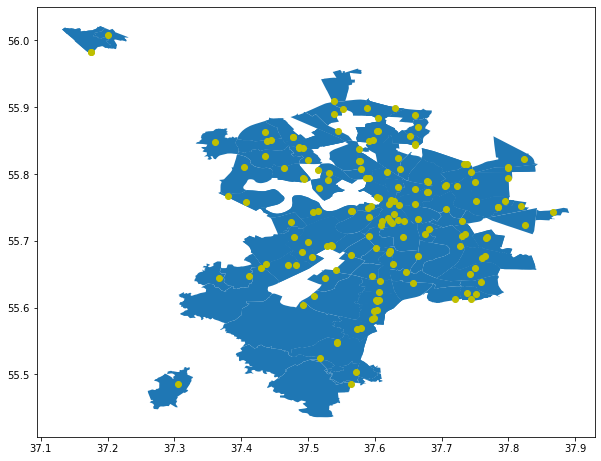

In [11]:
ax = msc_poly.plot(figsize=(10,10))
ax = msc_point.plot(ax=ax,figsize=(10,10),c='y')

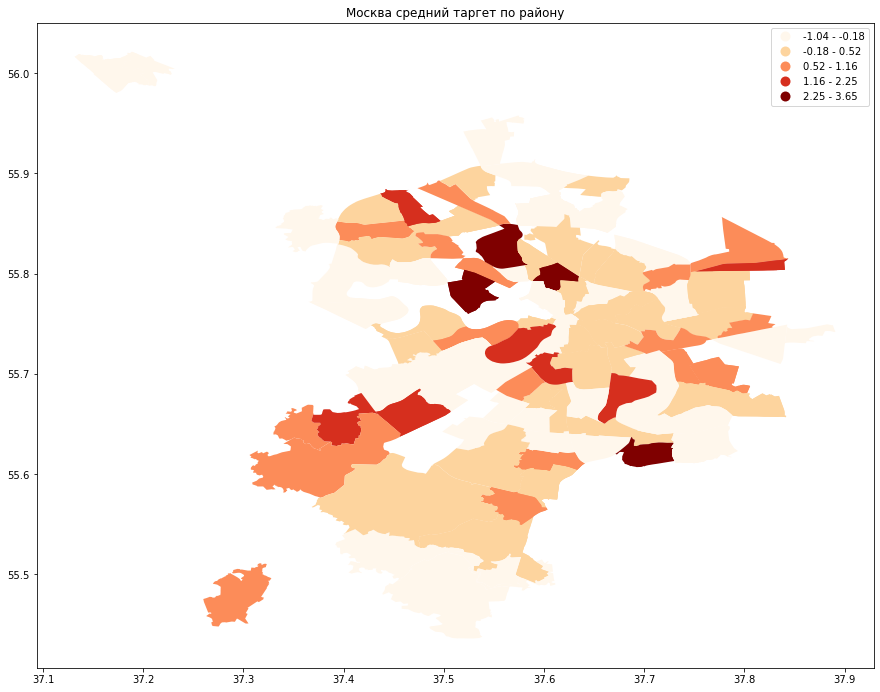

In [12]:
msc_poly.plot('target_mean',
           figsize=(15, 15),
           cmap='OrRd',
           scheme='NaturalBreaks',
           legend=True);
plt.title('Москва средний таргет по району')
plt.show()

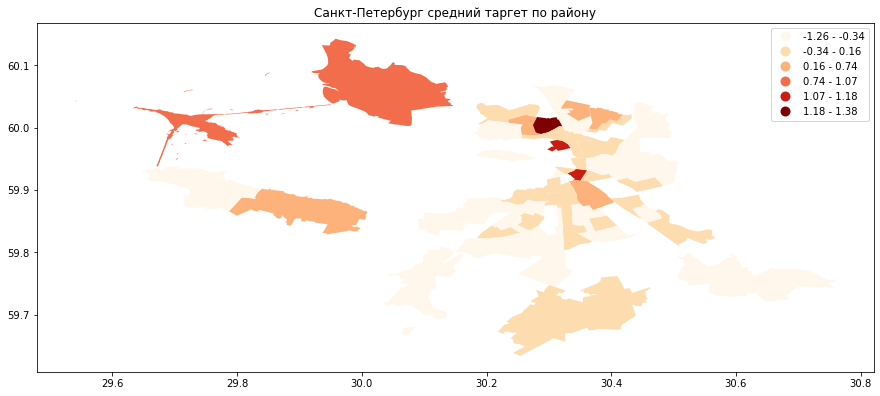

In [13]:
spb_poly.plot('target_mean',
           figsize=(15, 15),
           cmap='OrRd',
            scheme='HeadTailBreaks',
           legend=True);
plt.title('Санкт-Петербург средний таргет по району')
plt.show()

In [14]:
import folium
from folium.plugins import HeatMap,  MarkerCluster
m = folium.Map(location=[55.752491, 37.617406], 
               zoom_start=10, 
               tiles='OpenStreetMap')

heat_data = [[row['lat'],row['lon']] for index, row in train_poly.iterrows()]

HeatMap(heat_data,
        radius=25).add_to(m)
MarkerCluster(heat_data).add_to(m)
m

In [15]:
m = folium.Map(location=[59.939797, 30.333710], 
               zoom_start=10, 
               tiles='OpenStreetMap')
HeatMap(heat_data,
        radius=25).add_to(m)

m

In [16]:
from keplergl import KeplerGl

In [748]:
kp_data = msc_poly['geometry'].reset_index(drop=True).to_frame()

In [17]:
kg_map= KeplerGl()
kg_map.add_data(msc_poly)
kg_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'unnamed': {'index': [7935, 7935, 7935, 7935, 13386, 13386, 13386, 2705, 2705, 2705, 2705, 8113…